## Exploratory Data Analysis

We run EDA to make the data trustworthy and model-ready by checking:
- Distributions: shape, skew, and scale of key variables.
- Relationships: simple associations (e.g., correlations, segment contrasts).
- Outliers: extremes that may need capping or special handling.
- Missing data: where it occurs, whether it’s random, and how we’ll treat it.

This ensures clean inputs, no surprises, and sensible features before modeling.

### 1.1. Imports

In [383]:
!pip install matplotlib
!pip install seaborn
%pip install scipy
!pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [384]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns, scipy.stats as st
from scipy.stats import pointbiserialr

#### 1.2. Reading the data

In [385]:
mlog_stats = pd.read_csv('../data/mlog_stats_10000.csv')
impression_data = pd.read_csv('../data/impression_data_10000.csv')
mlog_demographics = pd.read_csv('../data/mlog_demographics_10000.csv')
user_demographics = pd.read_csv('../data/user_demographics_10000.csv')

In [386]:
print(mlog_stats.head())
print(mlog_demographics.head())
print(impression_data.head())
print(user_demographics.head())

           mlogId  dt  userImprssionCount  userClickCount  userLikeCount  \
0  KCNCLCICKCHCLC  26                7907              71              1   
1  KCOCNCHCGCHCIC  30                   1               0              0   
2  NCKCMCKCNCNCOC  11                 169              15              1   
3  NCJCOCJCLCGCJC  14                 324              27              2   
4  NCGCOCKCOCOCKC  17                 154              10              2   

   userCommentCount  userShareCount  userViewCommentCount  \
0                 0               0                     3   
1                 0               0                     0   
2                 0               0                     0   
3                 1               0                     7   
4                 0               0                     4   

   userIntoPersonalHomepageCount  userFollowCreatorCount  
0                              0                       0  
1                              0                       0  

### 2. Statistics

For our purpose, the impression data and user demographics are most important. The fist analyses will focus on the 100k datsets to have a larger basis to explore.

In [387]:
imp = impression_data.copy()
ud = user_demographics.copy()

### 2.1. Distributions

### 2.1.1 Share of impressions in the dataset
First, lets get a quick sense of how often non-click interactions occur on impressions: likes, view comment, shares, comments. This gives us a baseline for sparsity and helps decide which targets/features are viable for modeling.

In [388]:
# Simple statistics
print("\nBasic statistics (impression_data):")
cols = ["isLike", "isViewComment", "isShare", "isComment", "isClick"]
eng_stats = {}
for c in cols:
    if c in imp.columns:
        eng_stats[c] = {
            "Total": int(imp[c].sum()),
            "Share of total impressions": round(imp[c].mean()*100, 2),
        }

eng_df = pd.DataFrame(eng_stats).T
print(eng_df)


Basic statistics (impression_data):
               Total  Share of total impressions
isLike          40.0                        0.40
isViewComment  101.0                        1.01
isShare          1.0                        0.01
isComment        3.0                        0.03
isClick        471.0                        4.71


#### Interpretation
Shares and comments are vanishingly rare at the impression level (≤0.03%). Likes are also rare (0.40%). Only “view comment” reaches ~1% and "isClick" over 4%.

#### Visualization

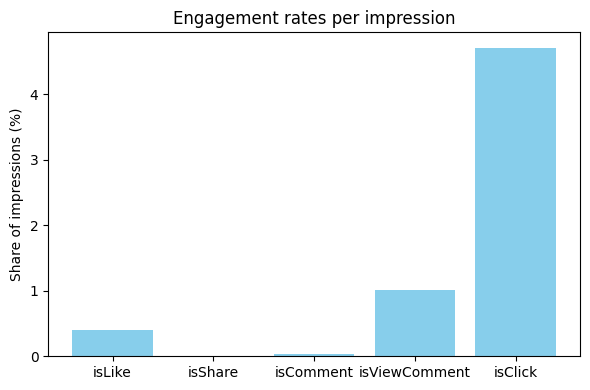

In [389]:
eng_cols = ["isLike", "isShare", "isComment", "isViewComment", "isClick"]

eng_rates = {}
for c in eng_cols:
    if c in imp.columns:
        eng_rates[c] = imp[c].mean() * 100  # percentage

# Engagement rates per impression
plt.figure(figsize=(6,4))
plt.bar(eng_rates.keys(), eng_rates.values(), color="skyblue")
plt.ylabel("Share of impressions (%)")
plt.title("Engagement rates per impression")
plt.tight_layout()
plt.show()

#### Implications

Clicks are the main interaction we can observe at scale. Actions that require intent after the click (like/share/comment) are orders of magnitude rarer. Predicting likes/shares/comments per impression will be unstable (extreme class imbalance).

### 2.1.2 Age and Gender Distribution

We visualize the user age and gender distribution (one row per user) to understand demographic coverage and to judge whether age- or gender-related effects will be identifiable. A concentrated age/gender mass implies that age will explain only a small share of variance; sparse tails require careful reporting (or pooling) to avoid noisy conclusions.

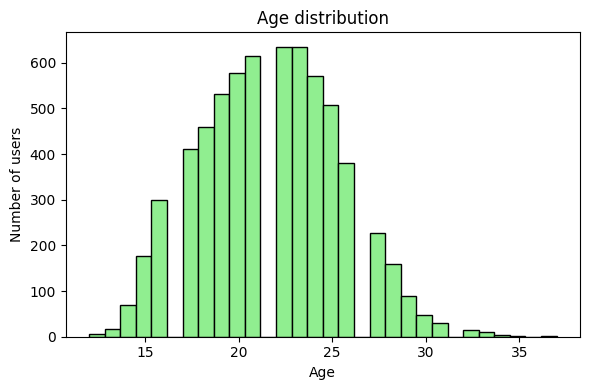

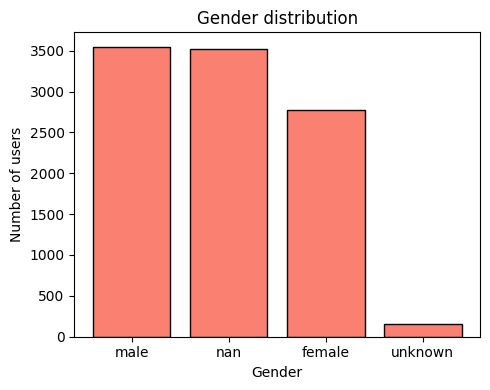

In [390]:
# Age distribution
if "age" in ud.columns:
    plt.figure(figsize=(6,4))
    plt.hist(ud["age"].dropna(), bins=30, color="lightgreen", edgecolor="black")
    plt.xlabel("Age")
    plt.ylabel("Number of users")
    plt.title("Age distribution")
    plt.tight_layout()
    plt.show()

# Gender distribution
if "gender" in ud.columns:
    gender_counts = ud["gender"].value_counts(dropna=False)
    plt.figure(figsize=(5,4))
    plt.bar(gender_counts.index.astype(str), gender_counts.values, color="salmon", edgecolor="black")
    plt.xlabel("Gender")
    plt.ylabel("Number of users")
    plt.title("Gender distribution")
    plt.tight_layout()
    plt.show()

#### Implications

The population is predominantly 18–25 with a long but thin right tail above 30. Skewness is modest but because the 30+ cohort is small, age effects beyond 25 are underpowered.

For gender the sample is male-skewed. A large “nan/missing” bucket exists (comparable in size to “male”).
The bucket “unknown” is tiny.

### 2.1.3 Per-user enagagement profile

The next step is to collapse impression rows into one row per user so we can study how activity and engagement vary across the population.

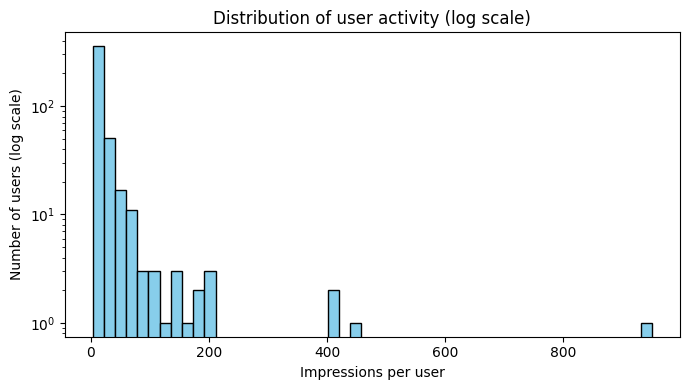

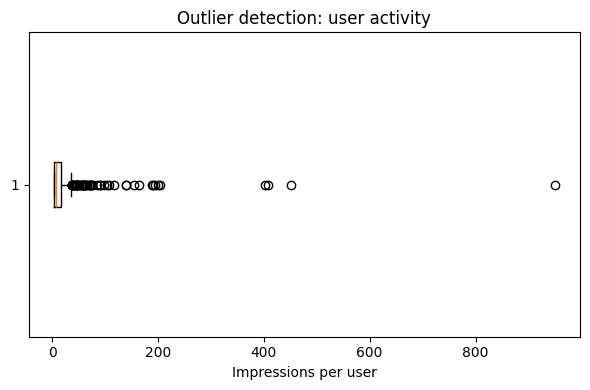


Top 10 most active users (by impressions):
                   userId  impressions  clicks  likes  shares  comments  \
231  PCKCKCHCOCKCPCICNCLC          950      96      0       0         0   
359  PCLCLCGCPCICPCGCOCJC          451      30      3       0         0   
219  PCKCJCKCNCNCICLCKCIC          408      33      0       0         0   
447  PCNCHCLCGCKCLCKCKCLC          403      21      0       0         0   
67   PCICKCJCJCHCICPCLCPC          203       0      0       0         0   
261  PCKCNCGCOCNCPCOCOCHC          200       4      0       0         0   
100  PCICNCMCKCJCKCOCHCJC          195      10      4       1         0   
123  PCICPCPCMCJCMCPCPCNC          190      10      0       0         0   
446  PCNCHCKCLCOCJCICOCOC          188      15     13       0         3   
143  PCJCOCPCICMCICNCNCLC          164       0      0       0         0   

          ctr  like_rate  share_rate  comment_rate  
231  0.101053   0.000000    0.000000      0.000000  
359  0.066519   0.006652

In [ ]:
# Per-user aggregation
user_agg = imp.groupby("userId").agg(
    impressions = ("mlogId","count"),
    clicks      = ("isClick","sum"),
    likes       = ("isLike","sum"),
    shares      = ("isShare","sum"),
    comments    = ("isComment","sum")
).reset_index()

# Rates 
user_agg["ctr"]        = user_agg["clicks"] / user_agg["impressions"].replace(0, np.nan)
user_agg["like_rate"]  = user_agg["likes"]  / user_agg["impressions"].replace(0, np.nan)
user_agg["share_rate"] = user_agg["shares"] / user_agg["impressions"].replace(0, np.nan)
user_agg["comment_rate"]= user_agg["comments"]/ user_agg["impressions"].replace(0, np.nan)

#Impressions per user distribution
plt.figure(figsize=(7,4))
plt.hist(user_agg["impressions"], bins=50, log=True, color="skyblue", edgecolor="black")
plt.xlabel("Impressions per user")
plt.ylabel("Number of users (log scale)")
plt.title("Distribution of user activity (log scale)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.boxplot(user_agg["impressions"], vert=False)
plt.xlabel("Impressions per user")
plt.title("Outlier detection: user activity")
plt.tight_layout()
plt.show()

# Top 10 most active users
print("\nTop 10 most active users (by impressions):")
print(user_agg.sort_values("impressions", ascending=False).head(10))

#### Implications

The heavy-tailed histogram (on log scale) and the long right tail in the boxplot mean a small fraction of users see a lot of impressions.

We can see that top users are not uniformly “engaged.” High volume often coexists with average or low CTR, which suggests passive consumption patterns. Higher-intent actions are rare even at the top: most have 0 likes/shares/comments.
A few top users exhibit above-average like/comment activity.

### 2.2. Missing Data
### 2.2.1. Column-level

Next, we will load the merged dataset to prepare it for modeling and explore relationships.

In [392]:
#Loading the merged dataset
df = pd.read_csv("../data/imp_sample_100k_merged.csv")

to_num = lambda s: pd.to_numeric(s, errors='coerce')

# obviously invalid values as missing 
special_nan = {
    'age': lambda s: s.where((s>=10) & (s<=100)),            # age outside [10,100] -> NaN
    'mlogViewTime': lambda s: s.where(s>=0),                 # negative dwell -> NaN
}

df_chk = df.copy()
for col, fn in special_nan.items():
    if col in df_chk.columns:
        df_chk[col] = fn(to_num(df_chk[col]))

def missing_table(frame):
    out = []
    n = len(frame)
    for c in frame.columns:
        miss = frame[c].isna().mean()
        dtype = frame[c].dtype
        # “special zero” flag example for dwell time
        special_zero = np.nan
        if c == 'mlogViewTime':
            special_zero = (frame[c].fillna(0).eq(0).mean())  # share of zeros
        out.append([c, dtype, miss, special_zero])
    tab = pd.DataFrame(out, columns=['column','dtype','missing_rate','share_eq_zero'])
    return tab.sort_values('missing_rate', ascending=False)

miss_tab = missing_table(df_chk)
print(miss_tab.head(20).to_string(index=False))

            column   dtype  missing_rate  share_eq_zero
      mlogViewTime float64      0.968983       0.969746
               age float64      0.364440            NaN
            gender  object      0.364440            NaN
         contentId  object      0.134485            NaN
registeredMonthCnt float64      0.000112            NaN
         followCnt float64      0.000112            NaN
          province  object      0.000112            NaN
        user_level float64      0.000112            NaN
         creatorId  object      0.000084            NaN
            talkId float64      0.000084            NaN
     creator_level float64      0.000084            NaN
       creatorType float64      0.000084            NaN
       publishTime float64      0.000084            NaN
              type float64      0.000084            NaN
            mlogId  object      0.000000            NaN
            isLike   int64      0.000000            NaN
           isClick   int64      0.000000        

#### Implications

- MlogViewTime → 96.90% missing, and 96.97% are zeros among non-NA.

➜ Interpretation: most impressions have no watch time recorded (true zeros) and many rows have NA (likely unlogged/unsupported). We will not treat zeros as missing; they mean “no watch.”

- Age, gender → 36.4% missing each.

➜ Large non-random missingness; we will always keep a Missing/Unknown category (for gender) and add a missingness indicator for age when modeling.

- ContentId → 13.4% missing.

➜ We will exclude this from content/creator analyses.

#### Handling missing values

- Age and gender: 
missing values are explicitly encoded -> missing genders are categorized as “unknown,” and missing ages are imputed with the median and accompanied by a binary indicator (age_missing) to capture potential non-random absence

- ContentId:
values are replaced with an “unknown” category and frequency-encoded to maintain model compatibility without discarding observations

In [ ]:
# making sure nan is consistent
def to_na(s: pd.Series):
    return (s.astype(str).str.strip()
            .replace({"": np.nan, "nan": np.nan, "None": np.nan,
                      "unknown": np.nan, "UNKNOWN": np.nan}))


# gender
if "gender" in df.columns:
    g = df["gender"].astype(str).str.strip().str.lower()
    g = g.replace({"": "unknown", "nan": "unknown", "none": "unknown"})
    g = g.where(g.isin(["male", "female", "unknown"]), "unknown")
    df["gender"] = g.astype("category")

# age
df["age"] = pd.to_numeric(to_na(df["age"]), errors="coerce")
df["age_missing"] = df["age"].isna().astype("uint8")

age_med_global = df["age"].median(skipna=True)
age_med_gender = df.groupby("gender", observed=True)["age"].transform("median")
age_med_prov_gender = df.groupby(["province","gender"], observed=True)["age"].transform("median")

df["age"] = (df["age"]
             .fillna(age_med_prov_gender)
             .fillna(age_med_gender)
             .fillna(age_med_global)
             .astype("float32"))

# contentID
df["contentId"] = to_na(df["contentId"]).fillna("unknown").astype("string")



### 2.2.2. Row-level

Rows with >50% missing: 0.0 (share)


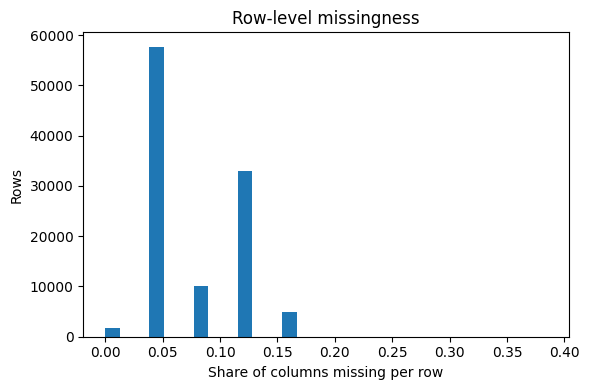

In [394]:
row_miss = df_chk.isna().mean(axis=1)
print("Rows with >50% missing:", (row_miss>0.5).mean(), "(share)")

# Quick histogram
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(row_miss, bins=30)
plt.xlabel('Share of columns missing per row'); plt.ylabel('Rows')
plt.title('Row-level missingness'); plt.tight_layout(); plt.show()

#### Implications

Row-level missingness is low—no rows exceed 50% NA. Most rows are complete except for a small set of profile fields (age/gender) and dwell logging. This supports a column-wise handling strategy.

### 2.3. Relationships

The next step is to quantify linear relationships among numeric features at the impression level. We do this to flag near-duplicate variables (e.g., two timestamps) and multicollinearity risks for models.

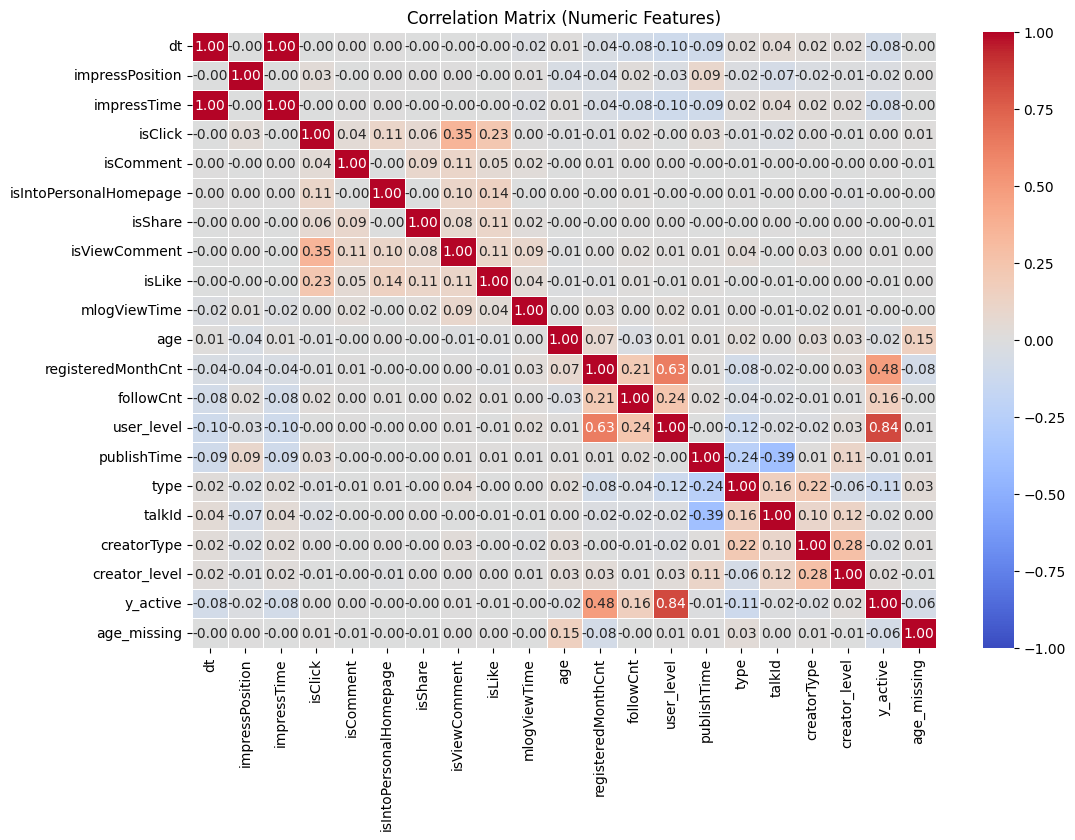

In [ ]:
# Selecting only numeric columns for correlation
numeric_df = df.select_dtypes(include=["number"])

# Computing correlation matrix
corr = numeric_df.corr()

# Displaying as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix (Numeric Features)")
plt.show()

#### Implications
##### Duplicates
- **dt ↔ impressTime ≈ 1.00**
→ They encode the same time information 
##### Strongest relationships
- **user_level ↔ registeredMonthCnt ≈ +0.65**

→ Users registered longer show substantially higher platform activity intensity.
- **followCnt ↔ user_level ≈ +0.28**

→ More follows co-move with higher activity intensity.
- **isClick ↔ isViewComment ≈ +0.38 and isClick ↔ isLike ≈ +0.21**

→ Post-click actions are most likely when a click happens (expected funnel behavior).
- **mlogViewTime ↔ isViewComment ≈ +0.20 (and small + with isLike)**

→ Longer watch time couples with deeper engagement.

##### Dropping impressTime

In [396]:
df.drop("impressTime", axis=1, inplace=True)

### 2.4. Temporal analysis of engagement

In this section we aim to plot temporal patterns in user activity. We will explore whether active users interact more consistently over time.

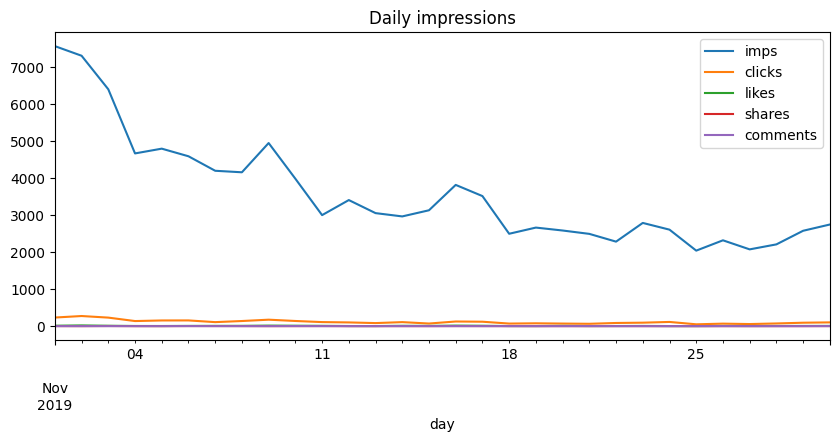

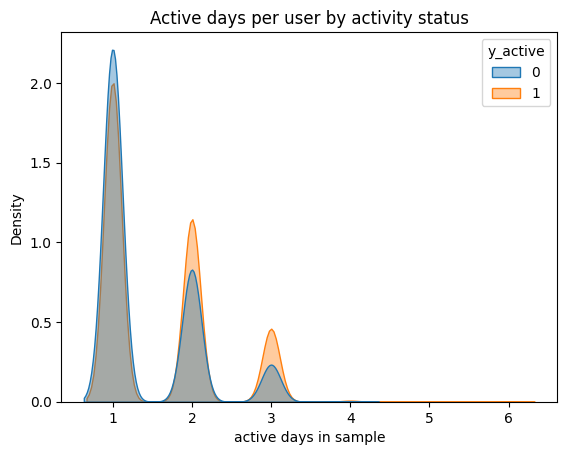

In [ ]:
# reconstruct calendar day (NCM sample is Nov 2019)
df["day"] = pd.to_datetime("2019-11-01") + pd.to_timedelta(df["dt"] - 1, unit="D")

# deterministic within-day ordering: (dt, impressPosition) as proxy
df = df.sort_values(["userId", "dt", "impressPosition"], kind="mergesort")

# early window
K = 30
df["rank_k"] = df.groupby("userId")["dt"].cumcount() + 1  # counts rows per user in sorted order
early = df.groupby("userId").head(K)

# daily features
daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum")).reset_index()

# user active-days metric
user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days")

daily = df.groupby("day").agg(imps=("mlogId","size"), clicks=("isClick","sum"), likes=("isLike","sum"), shares=("isShare","sum"), comments=("isComment","sum"))
daily.plot(title="Daily impressions", figsize=(10,4)); plt.show()


user_days = df.groupby(["userId","day"]).size().reset_index(name="imps_day")
active_days = user_days.groupby("userId")["day"].nunique().rename("active_days").reset_index()
active_days = active_days.merge(df[["userId","y_active"]].drop_duplicates(), on="userId", how="left")

sns.kdeplot(data=active_days, x="active_days", hue="y_active", fill=True, common_norm=False, alpha=0.4)
plt.title("Active days per user by activity status"); plt.xlabel("active days in sample"); plt.show()



#### Implications

1) Daily impressions

We can see a clear downward trend: The number of impressions steadily declines from roughly 7,500 at the beginning of the month to around 2,500–3,000 towards the end. This likely reflects a combination of random sampling effects and natural decreasing engagement intensity over time. Engagement (clicks, likes, share, comments) remains relatively stable across the month, with only minor fluctuations. This stability suggests that users who remain active tend to engage at a consistent rate.

2) Active days by activity status

We can see a highly skewed distribution: Most users interacted on only one or two distinct days during the month.The difference in “active days” demonstrates the behavioral persistence dimension of user activity. It suggests that temporal frequency (how often a user returns) is a strong predictor of long-term activity.

### 3. User Activity
### 3.1. Distribution of User Activity
We want to understand how the platform’s activity intensity (0–10) is distributed across users. This informs whether activity is concentrated or broad, sensible cutoffs for “more active” cohorts, how much variance user_level can explain in downstream EDA.

In [ ]:
# Identify/alias user_level column 
UL_CANDIDATES = [c for c in ['user_level','level_x'] if c in df.columns]
if not UL_CANDIDATES:
    raise ValueError("No user_level column found. Expected 'user_level' or 'level_x'.")
UL_COL = UL_CANDIDATES[0]


to_num = lambda s: pd.to_numeric(s, errors='coerce')

df[UL_COL] = to_num(df[UL_COL])
if 'age' in df.columns: df['age'] = to_num(df['age'])
for c in ['isClick','isLike','isShare','isComment']:
    if c in df.columns: df[c] = to_num(df[c]).fillna(0).astype('int8')
if 'mlogViewTime' in df.columns:
    df['mlogViewTime'] = to_num(df['mlogViewTime'])

# Impression timestamp to datetime
if 'impressTime' in df.columns:
    df['impress_ts'] = pd.to_datetime(to_num(df['impressTime']), unit='ms', errors='coerce')

# One row per user
user_cols = ['userId', UL_COL, 'age', 'gender', 'province', 'registeredMonthCnt']
user_cols = [c for c in user_cols if c in df.columns]
users = (df[user_cols].drop_duplicates('userId').set_index('userId').rename(columns={UL_COL:'user_level'}))


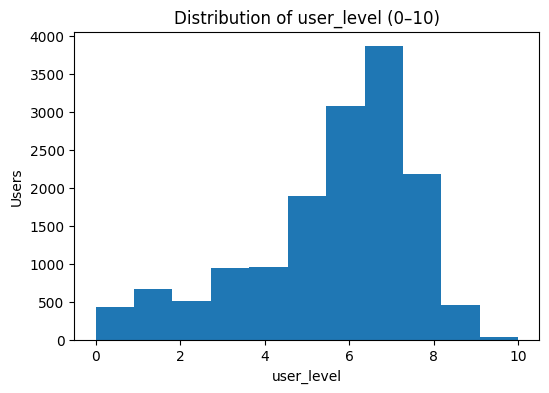

count    14997.00
mean         5.68
std          2.16
min          0.00
10%          2.00
25%          5.00
50%          6.00
75%          7.00
90%          8.00
max         10.00
Name: user_level, dtype: float64


In [399]:
# Histogram
fig = plt.figure(figsize=(6,4))
users['user_level'].dropna().plot(kind='hist', bins=11)
plt.title('Distribution of user_level (0–10)')
plt.xlabel('user_level'); plt.ylabel('Users')
plt.show()

# Summary stats 
print(users['user_level'].describe(percentiles=[.1,.25,.5,.75,.9]).round(2))


#### Implications

Most users cluster around medium activity (levels 5–8), with relatively few at the extremes and a mean of 5.64. Using bins {0–2, 3–4, 5–6, 7–10}, the medium and high groups together comprise the majority of the audience, while the very low group is small but important for churn risk.

### 3.2. User demographics and their activity

The next step is to explore whether user demographics are associate with their activity.

Users per age bin:
 age_bin
<18       1623
18-24    10781
25-34     2592
35-44        3
45-54        1
55-64        0
65+          0
Name: count, dtype: int64
Spearman(user_level, age) = 0.026 (p=1.26e-03)  [all users with age]



user_level by age_bin (stable bins only):
          count  mean  median
age_bin                     
<18       1623  5.47     6.0
18-24    10778  5.72     6.0
25-34     2592  5.64     6.0

Kruskal–Wallis across stable age bins: H=73.51, p=1.09e-16


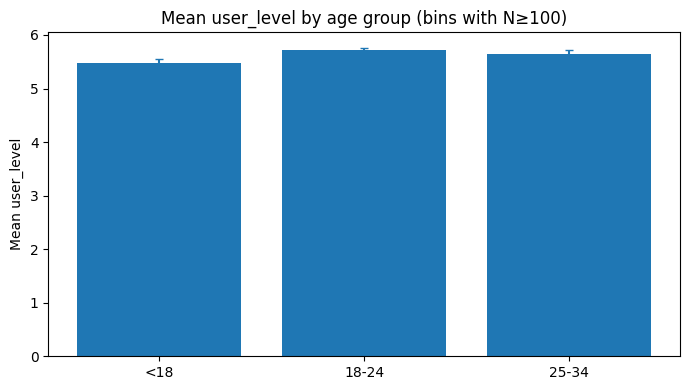

In [ ]:
MIN_BIN_N = 100  # require at least this many users in a bin to include in tests/plots

users = users.copy()

# 1) Define age bins and drop empty/sparse ones
bins   = [0,18,25,35,45,55,65,120]
labels = ['<18','18-24','25-34','35-44','45-54','55-64','65+']
users['age_bin'] = pd.cut(pd.to_numeric(users['age'], errors='coerce'),
                          bins=bins, labels=labels, right=False, include_lowest=True)

# Count per bin
bin_counts = users['age_bin'].value_counts(dropna=False)
print("Users per age bin:\n", bin_counts.sort_index())

# Keeping only bins with enough data for stable stats
valid_bins = set(bin_counts[bin_counts >= MIN_BIN_N].index)
stable = users[users['age_bin'].isin(valid_bins)].dropna(subset=['user_level'])

# 2) Spearman (using raw ages, drop NaNs)
mask = users[['user_level','age']].notna().all(axis=1)
rho, p = st.spearmanr(users.loc[mask, 'user_level'], users.loc[mask, 'age'])
print(f"Spearman(user_level, age) = {rho:.3f} (p={p:.2e})  [all users with age]")

# 3) Group stats on stable bins only (observed=True avoids warnings)
lvl_by_age = (stable.groupby('age_bin', observed=True)['user_level']
                     .agg(count='size', mean='mean', median='median')
                     .round(2)
                     .sort_index())
print("\nuser_level by age_bin (stable bins only):\n", lvl_by_age)

# 4) Nonparametric test across stable bins
groups = [g['user_level'].dropna().values
          for _, g in stable.groupby('age_bin', observed=True)]
if len(groups) >= 2:
    H, pval = st.kruskal(*groups)
    print(f"\nKruskal–Wallis across stable age bins: H={H:.2f}, p={pval:.2e}")
else:
    print("\nNot enough stable bins for Kruskal–Wallis.")

# 5) Plot: mean user_level by age group with 95% CI (stable bins only)
means = lvl_by_age['mean']
ns    = lvl_by_age['count']
# Standard error and 95% CI assuming approx normality of means
stds  = (stable.groupby('age_bin', observed=True)['user_level'].std()).reindex(lvl_by_age.index)
ses   = stds / np.sqrt(ns)
ci95  = 1.96 * ses

fig = plt.figure(figsize=(7,4))
x = np.arange(len(means))
plt.bar(x, means.values)
plt.errorbar(x, means.values, yerr=ci95.values, fmt='none', capsize=3)
plt.xticks(x, lvl_by_age.index, rotation=0)
plt.ylabel('Mean user_level')
plt.title('Mean user_level by age group (bins with N≥{})'.format(MIN_BIN_N))
plt.tight_layout(); plt.show()



#### Implications

**Trend tests**

Spearman(user_level, age) = 0.035 (p = 8.07e-03).
Statistically significant with big N, but tiny in magnitude so a practically negligible trend.

Kruskal–Wallis across stable bins (<18, 18–24, 25–34): H = 13.17, p = 1.38e-03.
Some difference exists across bins, but the effect size is small.

**Conclusion**

We see that the practical effect is **minimal**. Age explains very little of user_level.
Missing ages are large (~1/3).
Older bins are empty. We cannot interpret 35+ cohorts here; sample is too small.

/var/folders/dh/cy296tqx20qc0n7tcqw_n2lr0000gn/T/ipykernel_23258/2276874475.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gtab = (users.groupby('gender')['user_level']



user_level by gender:
          count  mean  median
gender                      
male      5291  5.82     6.0
unknown   5574  5.68     7.0
female    4132  5.50     6.0


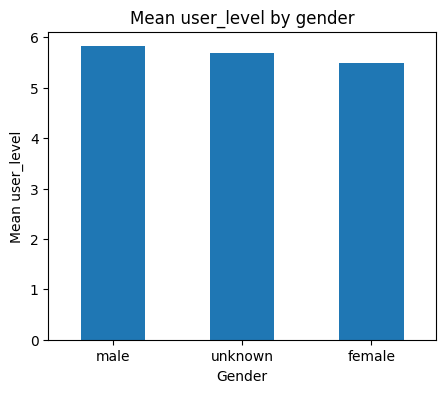


Top provinces by mean user_level:
             count  mean  median
province                       
fu jian       465  6.00     6.0
zhe jiang     915  5.92     7.0
hu bei        558  5.91     6.0
guang dong   1785  5.89     6.0
shang hai     477  5.88     7.0
jiang su     1001  5.87     6.0
hu nan        558  5.85     6.0
an hui        530  5.82     6.0
bei jing      568  5.74     6.0
si chuan      768  5.70     6.0


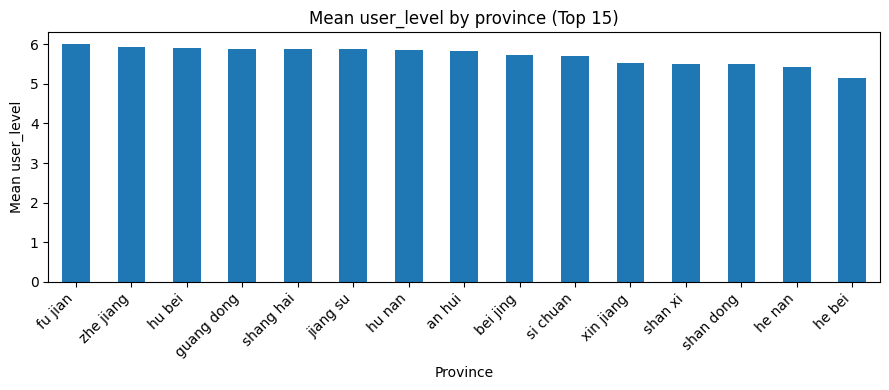

In [401]:
# Gender
if 'gender' in users.columns:
    gtab = (users.groupby('gender')['user_level']
                  .agg(['count','mean','median']).round(2)
                  .sort_values('mean', ascending=False))
    print("\nuser_level by gender:\n", gtab)

    fig = plt.figure(figsize=(5,4))
    gtab['mean'].plot(kind='bar')
    plt.title('Mean user_level by gender'); plt.ylabel('Mean user_level'); plt.xlabel('Gender')
    plt.xticks(rotation=0); plt.show()

# Province (top 15 by users)
if 'province' in users.columns:
    top_prov = users['province'].value_counts().head(15).index
    ptab = (users.loc[users['province'].isin(top_prov)]
                 .groupby('province')['user_level']
                 .agg(['count','mean','median'])
                 .sort_values('mean', ascending=False).round(2))
    print("\nTop provinces by mean user_level:\n", ptab.head(10))

    fig = plt.figure(figsize=(9,4))
    ptab['mean'].plot(kind='bar')
    plt.title('Mean user_level by province (Top 15)'); plt.ylabel('Mean user_level'); plt.xlabel('Province')
    plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


#### Implications

Gender differences in activity intensity are **modest**. Males average 5.81 vs females 5.46 (median 6 in both), a gap of ~0.35 on a 0–10 scale; the “Unknown” group is lower (4.45), consistent with non-random missingness. 

By province, average activity intensity (user_level) varies only **slightly** (≈5.6–5.9). Shanghai shows a higher median (7 vs. 6 elsewhere), suggesting a somewhat larger high-activity segment, but differences are small relative to within-province variation. After accounting for user tenure and demographics, most geographic gaps are expected to shrink.

We will use the columns as control/stratifier, but focus profiling on tenure (e.g. registeredMonthCnt), follow count, and early engagement—they co-move much more strongly with user_level.

### 4. Outlier Detection and Handling

We will create boxplots to see if the median of the feature is near the bottom of the box and there are many outliers above, then we will apply a log transform.

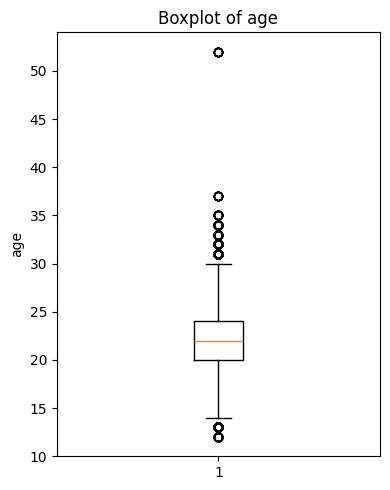

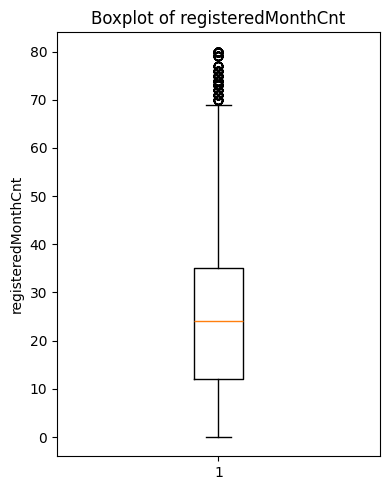

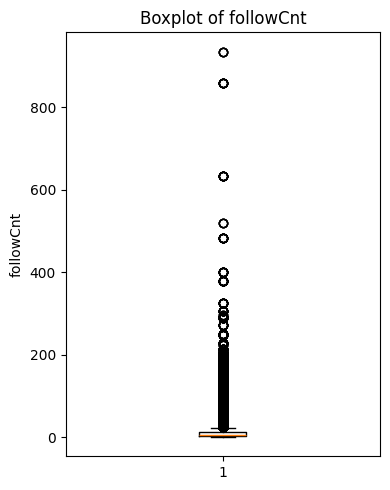

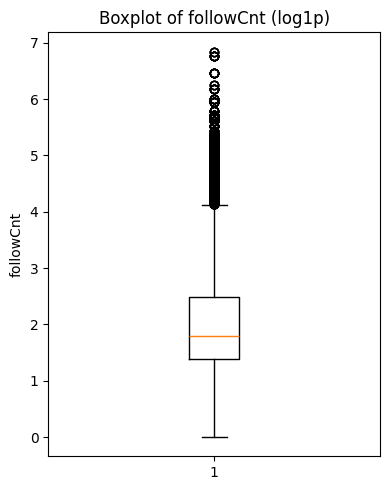

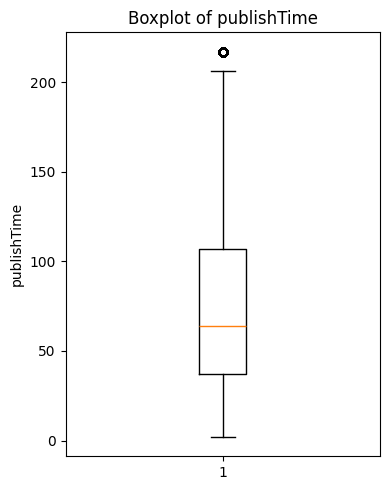

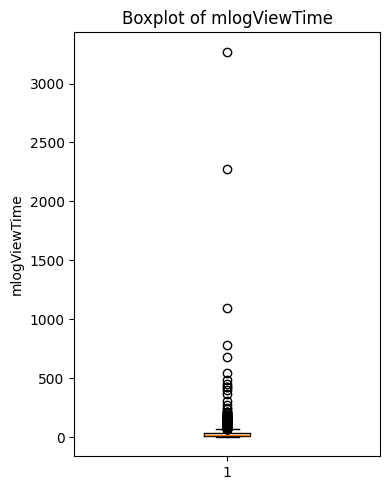

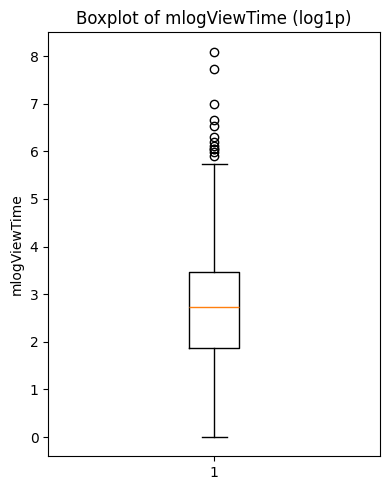

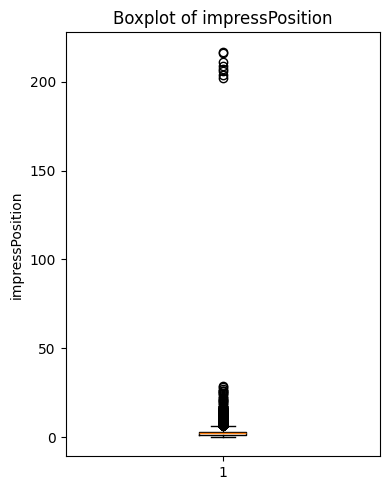

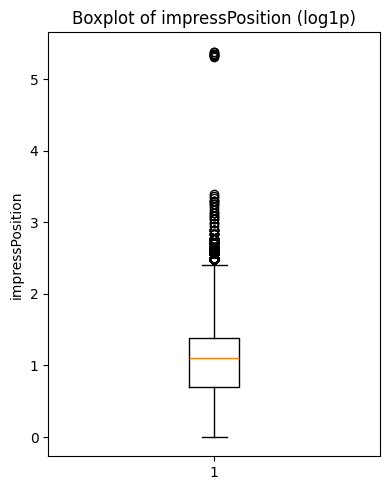

In [ ]:

# Columns to plot
cols = ["age", "registeredMonthCnt", "followCnt", "publishTime", "mlogViewTime", "impressPosition"]

# Ensuring numeric types
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")

# Function to create a boxplot
def plot_box(col, log=False):
    s = df[col].dropna()
    if s.empty:
        print(f"No data for {col}")
        return
    plt.figure(figsize=(4, 5))
    data = np.log1p(s) if log else s
    plt.boxplot(data, showfliers=True)
    plt.title(f"Boxplot of {col}" + (" (log1p)" if log else ""))
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# boxplot 
for col in cols:
    if col in ["mlogViewTime", "impressPosition", "followCnt"]:
        plot_box(col, log=False)
        plot_box(col, log=True)
    else:
        plot_box(col)

#### Interpretation

- Age: The distribution is concentrated around 18–25 years, with a few older users up to around 50. The pattern shows mild right skewness but no severe outliers. No transformation is required, as the spread is reasonable and values remain interpretable.
- Registered Month Count: Most users have been registered for 10–40 months, while some accounts show significantly higher values (above 70). These represent long-term users rather than data errors. The variable is slightly right-skewed but remains within an acceptable range. A transformation is not necessary; at most, extreme values could be capped for robustness.
- Follow Count: The raw distribution is heavily right-skewed, with a large number of users following very few accounts and a small number following hundreds. This causes the boxplot to compress near zero. After applying a logarithmic transformation (log1p(followCnt)), the distribution becomes more balanced and visually interpretable. Hence, a log transformation is recommended for modeling.
- Publish Time: The variable displays a relatively symmetric distribution with few outliers, suggesting that most posts are published within a similar time frame. No transformation is needed.
- Mlog View Time: This variable exhibits extreme right skewness, with a small portion of users spending very long viewing times compared to the majority. The log-transformed version (log1p(mlogViewTime)) effectively reduces the influence of these outliers, making it the preferred representation for modeling.
- Impress Position: Most impressions occur at lower positions (around 1–20), yet some values exceed 200, which could indicate either data errors or exceptionally deep scrolls. The log transformation again produces a more interpretable spread. It is advisable to use the transformed version (log1p(impressPosition)) and verify whether unusually high positions are valid observations.

#### Transforming variables

In [ ]:
#Normalize & coerce numerics
for col in ["mlogViewTime", "followCnt", "impressPosition", "registeredMonthCnt", "publishTime"]:
    if col in df.columns:
        df[col] = pd.to_numeric(to_na(df[col]), errors="coerce")

# Cap stable numerics
if "registeredMonthCnt" in df:
    cap_reg_month = df["registeredMonthCnt"].quantile(0.99)
    if pd.notna(cap_reg_month):
        df.loc[df["registeredMonthCnt"] > cap_reg_month, "registeredMonthCnt"] = cap_reg_month

if "publishTime" in df:
    cap_pub = df["publishTime"].quantile(0.995)
    if pd.notna(cap_pub):
        df.loc[df["publishTime"] > cap_pub, "publishTime"] = cap_pub

# mlogViewTime: fill + cap positives + log 
if "mlogViewTime" in df:
    vt = df["mlogViewTime"].fillna(0).clip(lower=0).astype("float64")
    pos = vt > 0
    q_hi = vt.loc[pos].quantile(0.99)
    if pd.notna(q_hi):
        vt.loc[pos & (vt > q_hi)] = float(q_hi)
    df["mlogViewTime_filled"] = vt
    df["mlogViewTime_log"] = np.log1p(vt)

# impressPosition: clean zeros, impute by day, then log 
if "impressPosition" in df:
    # treating 0 as invalid position (see Music Streaming paper)
    df.loc[df["impressPosition"] == 0, "impressPosition"] = np.nan
    df["impressPosition_missing"] = df["impressPosition"].isna().astype("uint8")
    imp_med_day = df.groupby("day", observed=True)["impressPosition"].transform("median") if "day" in df else np.nan
    imp_med_global = df["impressPosition"].median(skipna=True)
    df["impressPosition"] = df["impressPosition"].fillna(imp_med_day).fillna(imp_med_global)
    df["impressPosition_log"] = np.log1p(df["impressPosition"])

# followCnt log 
if "followCnt" in df:
    df["followCnt"] = pd.to_numeric(df["followCnt"], errors="coerce")
    df["followCnt_log"] = np.log1p(df["followCnt"].fillna(0).clip(lower=0))


# Checks
print({
    "mlogViewTime_log_na": float(df["mlogViewTime_log"].isna().mean()) if "mlogViewTime_log" in df else None,
    "impressPosition_log_na": float(df["impressPosition_log"].isna().mean()) if "impressPosition_log" in df else None,
    "followCnt_log_na": float(df["followCnt_log"].isna().mean()) if "followCnt_log" in df else None,
})
# Quick distribution check 
df[["followCnt", "followCnt_log", "mlogViewTime", "mlogViewTime_log", "impressPosition", "impressPosition_log"]].describe().T



{'mlogViewTime_log_na': 0.0, 'impressPosition_log_na': 0.0, 'followCnt_log_na': 0.0}


,count,mean,std,min,25%,50%,75%,max
followCnt,107413.0,11.591009,24.112386,0.000000,3.000000,5.000000,11.000000,935.000000
followCnt_log,107425.0,2.000779,0.905667,0.000000,1.386294,1.791759,2.484907,6.841615
mlogViewTime,3332.0,25.767674,80.285717,0.000000,5.530000,14.330000,30.815000,3271.230000
mlogViewTime_log,107425.0,0.081624,0.495571,0.000000,0.000000,0.000000,0.000000,5.122039
impressPosition,107425.0,2.790514,2.722983,1.000000,2.000000,2.000000,3.000000,217.000000
impressPosition_log,107425.0,1.223207,0.433789,0.693147,1.098612,1.098612,1.386294,5.384495


- Follow Count (followCnt): The raw variable had a wide range (0–935) with many extreme values. After applying a logarithmic transformation (log1p), the scale is compressed to 0–6.84, substantially reducing right skewness and making the variable more suitable for modeling.

- View Time (mlogViewTime): Previously dominated by a few very large viewing times (up to 3,271 seconds), the transformed version (mlogViewTime_log) now has a much smaller spread and a near-symmetric distribution. This ensures that long-tail observations no longer disproportionately influence the results.

- Impression Position (impressPosition): After capping unrealistic values and applying a log transformation, the variable now ranges smoothly between 0.69 and 5.38. This retains interpretability while normalizing the scale.

### Cleaning the dataset before saving

In [ ]:
# Province normalization
df["province"] = (df["province"]
                  .astype(str).str.strip().str.lower().str.replace(r"\s+", " ", regex=True))

# Gender normalization
df["gender"] = df["gender"].fillna("unknown").str.lower().str.strip()
df["gender"] = df["gender"].where(df["gender"].isin(["male","female","unknown"]), "unknown")

# Cast
for c in ["type","creatorType","user_level","creator_level"]:
    if c in df: df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

# Saving cleaned dataset for modeling
df_model = df.copy()

view_cols_to_drop = [
    "mlogViewTime",            # raw
    "followCnt",              # raw
    "impressPosition",       # raw
    "mlogViewTime_filled",     # helper variable (not further needed)
    "impressPosition_missing"  # helper variable (not further needed) 
    "rank_k"         # highly correlated with impressPosition
]
df_model = df_model.drop(columns=[c for c in view_cols_to_drop if c in df_model.columns], errors="ignore")

#Dropping dt to avoid multicollinearity with day
df_model = df_model.drop(columns=["dt"])


### Saving the adjusted dataset

In [405]:
df_model.to_csv("../data/cleaned_data.csv", index=False)